Logs   
- [2023/03/08]   
  Restart this notebook if you change the scratch library

- [2024/05/01]    
  You do not need to restart this notebook when updating the scratch library

To do list
- A review on centrality. A recent paper about centrality matrix is fascinating.  
  See (Engsig et al., 2024) - DomiRank Centrality reveals structural fragility  
  of complex networks via node dominance

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tqdm

from typing import NamedTuple, Dict, List, Tuple
from collections import deque, Counter
from scratch.linear_algebra import LinearAlgebra as la
from scratch.linear_algebra import Matrix, Vector
from IPython.display import display

Path = List[int]


In [3]:
%load_ext autoreload
%autoreload 2 

In [4]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

Several important terms in networks:

- nodes
- edges
- undirected
- directed

## Betweenness Centrality

The reason why we need to use *betweeness centrality* is to capture who is the    
key connector for given two peoples. The notion of *degree centrality* cannot   
capture this feature.

In [5]:
class User(NamedTuple):
  id_: int
  name: str

users = [User(0, "Hero"), User(1, "Dunn"), User(2, "Sue"), User(3, "Chi"),
         User(4, "Thor"), User(5, "Clive"), User(6, "Hicks"),
         User(7, "Devin"), User(8, "Kate"), User(9, "Klein")]

friend_pairs = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4),
                (4, 5), (5, 6), (5, 7), (6, 8), (7, 8), (8, 9)]

### The DataSciencester network

The DataSciencester network


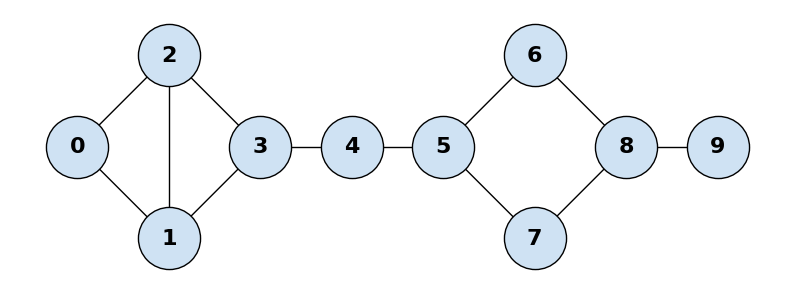

In [6]:
G = nx.Graph()
[G.add_node(user.id_) for user in users]
G.add_edges_from(friend_pairs)

fig, ax = plt.subplots(figsize=(10, 10))

node_pos = {
  0: (0, 2), 1: (1, 1), 2: (1, 3), 3: (2, 2), 4: (3, 2),
  5: (4, 2), 6: (5, 3), 7:(5, 1), 8: (6, 2), 9: (7, 2)}

nx.draw(G, pos=node_pos, with_labels=True, font_weight="bold", 
  node_color="#cfe2f3", node_size=2000, 
  edgecolors="k", ax=ax, font_size=16)

# nx.draw(G, with_labels=True, font_weight="bold", 
#   node_color="#cfe2f3", node_size=700, 
#   edgecolors="k", ax=ax)

ax.set_aspect("equal")
ax.set_ylim([0.6, 3.5])
# ax.set_title("The DataSciencester network")

print("The DataSciencester network")
plt.show(fig)

The friendship data will be easier to handle as a `dict`

In [7]:
# type alias for keeping track of Friendships
Friendships = Dict[int, List[int]]

friendships: Friendships = {user.id_: [] for user in users}

for i, j in friend_pairs:
  friendships[i].append(j)
  friendships[j].append(i)

print(friendships[4])
print(friendships[8])

friendships

[3, 5]
[6, 7, 9]


{0: [1, 2],
 1: [0, 2, 3],
 2: [0, 1, 3],
 3: [1, 2, 4],
 4: [3, 5],
 5: [4, 6, 7],
 6: [5, 8],
 7: [5, 8],
 8: [6, 7, 9],
 9: [8]}

To calculate *betweenness centrality* of node $i$, we add up, for every other   
pair of nodes $j$ and $k$, the proportion of shortest paths between node $j$   
and node $k$ that pass through $i$.

Now we have to build a function that can calculate the shortest paths between   
all pairs of peple. This algorithm is bread-firsth search.  See the textbook  
for the complete description

Deques are a generalization fo stacks and queues (the name pronounced "deck"   
and short for "double-ended queue"). Deques support thread-safe, memory efficient  
appends and pops from either side of the deque with approximately the smae $O(1)$  
performance in either direction.

In [8]:
for user in users:
  from_user_id = user.id_
  frontier = deque((from_user_id, friend_id)
                    for friend_id in friendships[from_user_id])
  print(frontier)

deque([(0, 1), (0, 2)])
deque([(1, 0), (1, 2), (1, 3)])
deque([(2, 0), (2, 1), (2, 3)])
deque([(3, 1), (3, 2), (3, 4)])
deque([(4, 3), (4, 5)])
deque([(5, 4), (5, 6), (5, 7)])
deque([(6, 5), (6, 8)])
deque([(7, 5), (7, 8)])
deque([(8, 6), (8, 7), (8, 9)])
deque([(9, 8)])


In [9]:
from_user_id = users[0].id_
frontier = deque((from_user_id, friend_id)
                  for friend_id in friendships[from_user_id])
print(frontier)
frontier.popleft()
print(frontier)
frontier.extend([(2, 3)])
print(frontier)

deque([(0, 1), (0, 2)])
deque([(0, 2)])
deque([(0, 2), (2, 3)])


In [10]:
a = {0: [[]], 1: [[2]]}

a.get(3, [])

[]

In [11]:
def shortest_paths_from(from_user_id: int, friendships: Friendships,
                        verbose=False) -> Dict[int, List[Path]]:
  # A dictionary from user_id to `all` shortest paths to that user.
  shortest_paths_to: Dict[int, List[Path]] = {from_user_id: [[]]}

  # [item 4.] A queue of (previous user, next user) that we need to check
  # Starts out with all pairs (from_user, friend_of_from_user).
  frontier = deque((from_user_id, friend_id)
                   for friend_id in friendships[from_user_id])
  
  # Keep going until we empty the queue
  while frontier:
    # Remove the pair that's next in the queue.
    prev_user_id, user_id = frontier.popleft()

    # Because of the way we're adding to the queue,
    # necessarily we already know some shortest paths to prev_user.
    paths_to_prev_user = shortest_paths_to[prev_user_id]
    new_paths_to_user = [path + [user_id] for path in paths_to_prev_user]

    # It's possible we already know a shortest path to user_id.
    # The second argunebt if .get is the default value when the key 
    # doesn't exist.
    old_paths_to_user = shortest_paths_to.get(user_id, [])

    # What's the shortest path to here that we've seen so far?
    if old_paths_to_user:
      min_path_length = len(old_paths_to_user[0])
    else:   # zero path length is the first situation where 
            # the path from_user to itself
      min_path_length = float('inf')

    if verbose:
      print(f"prev_user_id, user_id: {prev_user_id, user_id}")
      print(f"paths_to_prev_user: {paths_to_prev_user}")
      print(f"new_paths_to_user: {new_paths_to_user}")
      print(f"old_paths_to_user: {old_paths_to_user}")
      print(f"min_path_length: {min_path_length}")

    # Only keep paths that aren't too long and are actually new.
    # Update new_paths_to_user by comparing its path 
    # length to the old_paths_to_user
    new_paths_to_user = [path for path in new_paths_to_user
                          if len(path) <= min_path_length and path not in old_paths_to_user]

    # update shortest_paths_to user_id if the each path of new_paths_to_user
    # has len(path) less than or equal to min_path_length of old_paths_to_user
    # This will be update at least by an empty path (new_paths_to_user = [[]])
    shortest_paths_to[user_id] = old_paths_to_user + new_paths_to_user

    # Add never-seen neighbors to the frontier.
    frontier.extend((user_id, friend_id) for friend_id in friendships[user_id]
                      if friend_id not in shortest_paths_to)
    
    if verbose:
      print(f"new_paths_to_user: {new_paths_to_user}")
      print(f"shortest_paths_to: {shortest_paths_to}")
      print(f"frontier: {frontier}")
      print()
    
  return shortest_paths_to
    

In [12]:
shortest_paths_from(0, friendships, verbose=True)

prev_user_id, user_id: (0, 1)
paths_to_prev_user: [[]]
new_paths_to_user: [[1]]
old_paths_to_user: []
min_path_length: inf
new_paths_to_user: [[1]]
shortest_paths_to: {0: [[]], 1: [[1]]}
frontier: deque([(0, 2), (1, 2), (1, 3)])

prev_user_id, user_id: (0, 2)
paths_to_prev_user: [[]]
new_paths_to_user: [[2]]
old_paths_to_user: []
min_path_length: inf
new_paths_to_user: [[2]]
shortest_paths_to: {0: [[]], 1: [[1]], 2: [[2]]}
frontier: deque([(1, 2), (1, 3), (2, 3)])

prev_user_id, user_id: (1, 2)
paths_to_prev_user: [[1]]
new_paths_to_user: [[1, 2]]
old_paths_to_user: [[2]]
min_path_length: 1
new_paths_to_user: []
shortest_paths_to: {0: [[]], 1: [[1]], 2: [[2]]}
frontier: deque([(1, 3), (2, 3), (2, 3)])

prev_user_id, user_id: (1, 3)
paths_to_prev_user: [[1]]
new_paths_to_user: [[1, 3]]
old_paths_to_user: []
min_path_length: inf
new_paths_to_user: [[1, 3]]
shortest_paths_to: {0: [[]], 1: [[1]], 2: [[2]], 3: [[1, 3]]}
frontier: deque([(2, 3), (2, 3), (3, 4)])

prev_user_id, user_id: (2, 3

{0: [[]],
 1: [[1]],
 2: [[2]],
 3: [[1, 3], [2, 3]],
 4: [[1, 3, 4], [2, 3, 4]],
 5: [[1, 3, 4, 5], [2, 3, 4, 5]],
 6: [[1, 3, 4, 5, 6], [2, 3, 4, 5, 6]],
 7: [[1, 3, 4, 5, 7], [2, 3, 4, 5, 7]],
 8: [[1, 3, 4, 5, 6, 8],
  [2, 3, 4, 5, 6, 8],
  [1, 3, 4, 5, 7, 8],
  [2, 3, 4, 5, 7, 8]],
 9: [[1, 3, 4, 5, 6, 8, 9],
  [2, 3, 4, 5, 6, 8, 9],
  [1, 3, 4, 5, 7, 8, 9],
  [2, 3, 4, 5, 7, 8, 9]]}

Now let's compute all the shortest paths:

In [13]:
# For each from_user, for each to_user, a list of shortest paths.
shortest_paths = {user.id_: shortest_paths_from(user.id_, friendships)
                  for user in users}

shortest_paths

{0: {0: [[]],
  1: [[1]],
  2: [[2]],
  3: [[1, 3], [2, 3]],
  4: [[1, 3, 4], [2, 3, 4]],
  5: [[1, 3, 4, 5], [2, 3, 4, 5]],
  6: [[1, 3, 4, 5, 6], [2, 3, 4, 5, 6]],
  7: [[1, 3, 4, 5, 7], [2, 3, 4, 5, 7]],
  8: [[1, 3, 4, 5, 6, 8],
   [2, 3, 4, 5, 6, 8],
   [1, 3, 4, 5, 7, 8],
   [2, 3, 4, 5, 7, 8]],
  9: [[1, 3, 4, 5, 6, 8, 9],
   [2, 3, 4, 5, 6, 8, 9],
   [1, 3, 4, 5, 7, 8, 9],
   [2, 3, 4, 5, 7, 8, 9]]},
 1: {1: [[]],
  0: [[0]],
  2: [[2]],
  3: [[3]],
  4: [[3, 4]],
  5: [[3, 4, 5]],
  6: [[3, 4, 5, 6]],
  7: [[3, 4, 5, 7]],
  8: [[3, 4, 5, 6, 8], [3, 4, 5, 7, 8]],
  9: [[3, 4, 5, 6, 8, 9], [3, 4, 5, 7, 8, 9]]},
 2: {2: [[]],
  0: [[0]],
  1: [[1]],
  3: [[3]],
  4: [[3, 4]],
  5: [[3, 4, 5]],
  6: [[3, 4, 5, 6]],
  7: [[3, 4, 5, 7]],
  8: [[3, 4, 5, 6, 8], [3, 4, 5, 7, 8]],
  9: [[3, 4, 5, 6, 8, 9], [3, 4, 5, 7, 8, 9]]},
 3: {3: [[]],
  1: [[1]],
  2: [[2]],
  4: [[4]],
  0: [[1, 0], [2, 0]],
  5: [[4, 5]],
  6: [[4, 5, 6]],
  7: [[4, 5, 7]],
  8: [[4, 5, 6, 8], [4, 5, 7, 8]],
 

Now we finally ready to compute betweenness centrality.    
For every pair of nodes $i$ and $j$, we know the $n$ shortest paths from $i$   
to $j$. Then, for each of those paths, we just add $1/n$ to the centrality of   
each node on the path

In [14]:
betweenness_centrality = {user.id_: 0.0 for user in users}

for source in users:
  for target_id, paths in shortest_paths[source.id_].items():
    if source.id_ < target_id:       # don't double count
      num_paths = len(paths)          # how many shortest paths?
      contrib = 1 / num_paths         # contribution to centrality
      for path in paths:
        for between_id in path:
          if between_id not in [source.id_, target_id]:
            betweenness_centrality[between_id] += contrib

betweenness_centrality

{0: 0.0,
 1: 3.5,
 2: 3.5,
 3: 18.0,
 4: 20.0,
 5: 20.5,
 6: 6.0,
 7: 6.0,
 8: 8.5,
 9: 0.0}

### Draw the network with betweenness centrality

The DataSciencester network sized by betweenness centrality


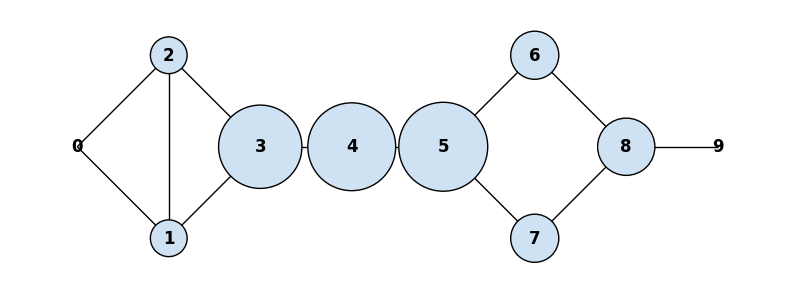

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

node_pos = {
  0: (0, 2), 1: (1, 1), 2: (1, 3), 3: (2, 2), 4: (3, 2),
  5: (4, 2), 6: (5, 3), 7:(5, 1), 8: (6, 2), 9: (7, 2)}
nx.draw(G, pos=node_pos, nodelist=G.nodes, 
  node_size=[200*size for size in betweenness_centrality.values()],
  with_labels=True, font_weight="bold", 
  node_color="#cfe2f3", edgecolors="k", ax=ax)

ax.set_aspect("equal")
ax.set_ylim([0.5, 3.5])
print("The DataSciencester network sized by betweenness centrality")
plt.show(fig)

### Closeness centrality

Closeness is 1/farness. The farness is the sum of the lengths
of its node shortest from all the other nodes.

In [16]:
def farness(user_id: int) -> float:
  """the sum of the lengths of the shortest paths to each other user""" 
  return sum(len(paths[0]) for paths in shortest_paths[user_id].values())

In [17]:
closeness_centrality = {user.id_: 1 / farness(user.id_) for user in users}
closeness_centrality

{0: 0.029411764705882353,
 1: 0.037037037037037035,
 2: 0.037037037037037035,
 3: 0.045454545454545456,
 4: 0.05,
 5: 0.05,
 6: 0.041666666666666664,
 7: 0.041666666666666664,
 8: 0.03571428571428571,
 9: 0.027777777777777776}

### Draw the network with closeness centrality

The DataSciencester network sized by closeness centrality


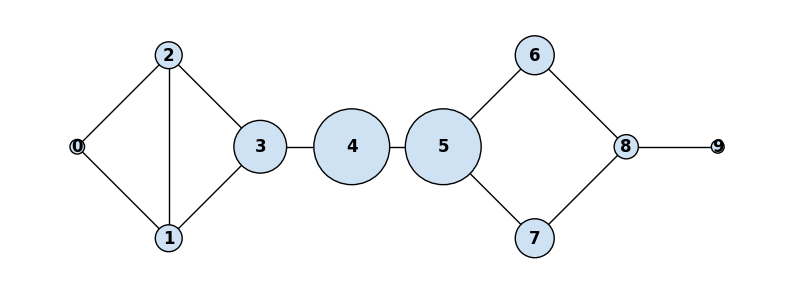

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))

node_pos = {
  0: (0, 2), 1: (1, 1), 2: (1, 3), 3: (2, 2), 4: (3, 2),
  5: (4, 2), 6: (5, 3), 7:(5, 1), 8: (6, 2), 9: (7, 2)}
nx.draw(G, pos=node_pos, nodelist=G.nodes, 
  node_size=[np.exp(160*size) for size in closeness_centrality.values()],
  with_labels=True, font_weight="bold", 
  node_color="#cfe2f3", edgecolors="k", ax=ax)

ax.set_aspect("equal")
ax.set_ylim([0.5, 3.5])
print("The DataSciencester network sized by closeness centrality")
plt.show(fig)

Computing of `shortest_paths` is not practical for large networks. That is why    
we need another quantity *eigenvector centrality* which is less intuitive

## Eigenvector Centrality

A review of eigenvector centrality and also PageRank centrality by   
(Sinn and Ziegler, 2022) - Landau On  Chess Tournaments and Google's PageRank.   
This paper is short and very nice story from Landau's idea to the solution   
robin chess tournament to the creation of hyperlink matrix and then  
Google PageRank matrix.

A better explanation can be read in 
[(Sacco, 2021) - Few but good, the eigenvector centrality and its meaning](
https://www.ancientworldmagazine.com/articles/few-good-eigenvector/)    

The interpretation of eigenvector centrality is the generalization of degree    
centrality (the higher the number connected neighborhood nodes, the higher the centrality    
of the given node.). These can be generalized by considering contribution    
of the neighborhood of neighborhood (second neighborhood), and continue   
until the contribution does not add up or lower the centrality of the given node.

A metaphor to understand this eigenvector centrality is the way to find out   
which person with her friends, including friends of her friends (second
neighborhood friends), third neighborhood friends, ..., are creating a good
quality of connecting people. As we can see in this simple example, we clearly
find that the nodes 0, 2, 1, and 3 creating a good connection among each others.

<img src="./img-resources/network-analysis-interpretation.png" width=500>

The following image is the calculation of eigenvector centrality for the node 0   
in third iteration, we have to grow the tree until there is no significant update  
to the degree centrality of the node 0.

### Matrix Multiplication

In [19]:
def entry_fn(m1=None, m2=None, nc1=None) -> float:
  """dot product of i-th row of m1 with j-th column of m2""" 
  return lambda i, j: sum(m1[i][k] * m2[k][j] for k in range(nc1))


def matrix_times_matrix(m1: Matrix, m2: Matrix) -> Matrix:
  nr1, nc1 = la.shape(m1)
  nr2, nc2 = la.shape(m2)

  assert nc1 == nc2, "must have (# of columns in m1) == (# of rows in m2)"

  return la.make_matrix(nr1, nc2, entry_fn(m1, m2, nc1))


def matrix_times_vector(m: Matrix, v: Vector) -> Vector:
  nr, nc = la.shape(m)
  n = len(v)
  assert nc == n, "must have (# of cols in m) == (# of elements in v)"

  return [la.dot(row, v) for row in m]    # output has length nr

Compute eigenvector by guessing and iterate to get a convergence
eigenvector.   
The algorithm to calculate this centrality is based on the recurrence relation   
below
$$
  \mathbf{x}_{i+1} = \frac{\mathbf{A} \, \mathbf{x}_i}{\Vert \mathbf{A} \mathbf{x}_i \Vert}
$$

The interpretation can be understood through this recurrence relation.    
For complete description, see `img-resources/network-analysis.drawio`

In [26]:
def find_eigenvector(m: Matrix, tolerance: float = 1e-5, rng=None, 
                      initialize_one: bool = False) \
  -> Tuple[Vector, float]:

  assert rng is not None, "You must provide rng with np.random.default_rng()"

  guess = rng.random(len(m[0]))
  if initialize_one:
    guess = np.ones(len(m[0]))

  total_iteration = 0
  while True:
    result = matrix_times_vector(m, guess)      # transform guess
    norm = la.magnitude(result)                 # compute norm
    next_guess = [x / norm for x in result]     # rescale

    if la.distance(guess, next_guess) < tolerance:
      # convergence so return (eigenvector, eigenvalue)
      return next_guess, norm

    print(f"iteration: {total_iteration}")
    print(" ", np.array(result)[:, np.newaxis]), 
    print(" ", norm)
    print(" ", np.array(next_guess)[:, np.newaxis])
    guess = next_guess
    total_iteration += 1

The algorithm above does not work for rotation matrix and reflection matrix.   
It will iterate (for rotation matrix) or swapping the element of vector   
(for reflection matrix) forever

### Centrality

In [27]:
def entry_fn_friend_pairs(i: int, j: int):
  return 1 if (i, j) in friend_pairs or (j, i) in friend_pairs else 0

n = len(users)
adjacency_matrix = la.make_matrix(n, n, entry_fn_friend_pairs)
adjacency_matrix

[[0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 1, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]

In [28]:
seed = None
rng = np.random.default_rng(seed)
eigenvector_centralities, _ = find_eigenvector(adjacency_matrix, rng=rng, 
                                                initialize_one=True)
eigenvector_centralities

iteration: 0
  [[2.]
 [3.]
 [3.]
 [3.]
 [2.]
 [3.]
 [2.]
 [2.]
 [3.]
 [1.]]
  7.874007874011811
  [[0.25400025]
 [0.38100038]
 [0.38100038]
 [0.38100038]
 [0.25400025]
 [0.38100038]
 [0.25400025]
 [0.25400025]
 [0.38100038]
 [0.12700013]]
iteration: 1
  [[0.76200076]
 [1.01600102]
 [1.01600102]
 [1.01600102]
 [0.76200076]
 [0.76200076]
 [0.76200076]
 [0.76200076]
 [0.63500064]
 [0.38100038]]
  2.558981652293387
  [[0.297775  ]
 [0.39703333]
 [0.39703333]
 [0.39703333]
 [0.297775  ]
 [0.297775  ]
 [0.297775  ]
 [0.297775  ]
 [0.24814583]
 [0.1488875 ]]
iteration: 2
  [[0.79406667]
 [1.09184167]
 [1.09184167]
 [1.09184167]
 [0.69480833]
 [0.893325  ]
 [0.54592083]
 [0.54592083]
 [0.7444375 ]
 [0.24814583]]
  2.588340663274941
  [[0.306786  ]
 [0.42183074]
 [0.42183074]
 [0.42183074]
 [0.26843775]
 [0.34513424]
 [0.21091537]
 [0.21091537]
 [0.28761187]
 [0.09587062]]
iteration: 3
  [[0.84366149]
 [1.15044748]
 [1.15044748]
 [1.11209923]
 [0.76696499]
 [0.69026849]
 [0.63274612]
 [0.632746

[0.3857800661495735,
 0.5147902322356226,
 0.5147902322356226,
 0.4733122039637769,
 0.23361029944966005,
 0.1501458150031844,
 0.08355561051056494,
 0.08355561051056494,
 0.07284034177922594,
 0.02729466013965243]

Users with high eigenvector centrality should be those who have a lot of   
connections, and connections to people who themselves have high centrality

### Draw the network with eigenvector centrality

The DataSciencester network sized by eigenvector centrality


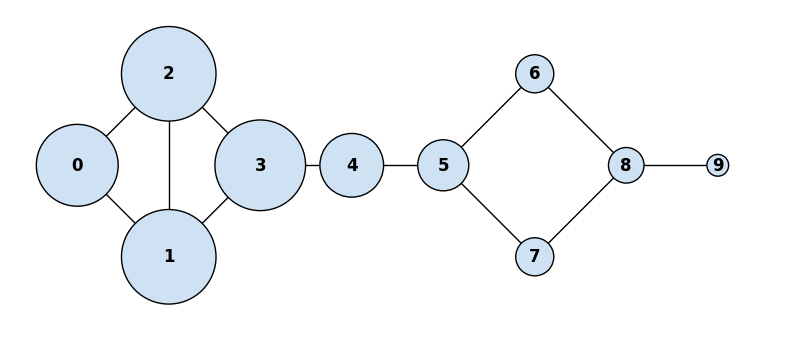

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))

node_pos = {
  0: (0, 2), 1: (1, 1), 2: (1, 3), 3: (2, 2), 4: (3, 2),
  5: (4, 2), 6: (5, 3), 7:(5, 1), 8: (6, 2), 9: (7, 2)}
nx.draw(G, pos=node_pos, nodelist=G.nodes, 
  node_size=[9000*size for size in eigenvector_centralities],
  with_labels=True, font_weight="bold", 
  node_color="#cfe2f3", edgecolors="k", ax=ax)

ax.set_aspect("equal")
ax.set_ylim([0.2, 3.7])
print("The DataSciencester network sized by eigenvector centrality")
plt.show(fig)

In small network, eigenvector centrality behaves erratically.  Adding and   
subtracting a node will have a great impact to the value of eigenvector.   
But in much larger network, this would not particularly be the case.

You can understand this by seeing what is the multiplication adjacency matrix   
and its eigenvector

## Directed Graphs and PageRank

We also have another data that show the endorsemnet target between users

In [23]:
endorsements = [
  (0, 1), (1, 0), (0, 2), (2, 0), (1, 2),
  (2, 1), (1, 3), (2, 3), (3, 4), (5, 4),
  (5, 6), (7, 5), (6, 8), (8, 7), (8, 9)]


The DataSciencester network of endorsements


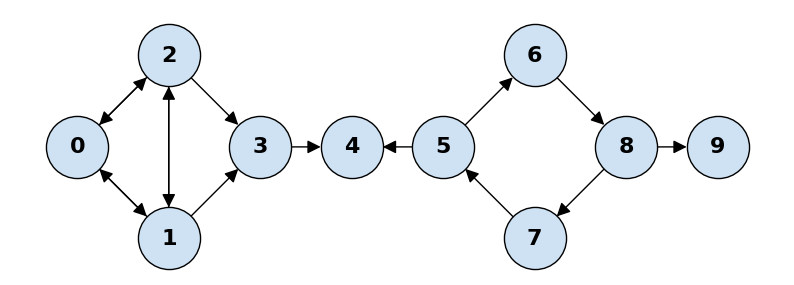

In [24]:
GDir = nx.DiGraph()
[GDir.add_node(user.id_) for user in users]
GDir.add_edges_from(endorsements)

fig, ax = plt.subplots(figsize=(10, 10))

node_pos = {
  0: (0, 2), 1: (1, 1), 2: (1, 3), 3: (2, 2), 4: (3, 2),
  5: (4, 2), 6: (5, 3), 7:(5, 1), 8: (6, 2), 9: (7, 2)}

nx.draw(GDir, pos=node_pos, with_labels=True, font_weight="bold", 
  node_color="#cfe2f3", node_size=2000, arrowsize=20,
  edgecolors="k", ax=ax, font_size=16)

# nx.draw(G, with_labels=True, font_weight="bold", 
#   node_color="#cfe2f3", node_size=700, 
#   edgecolors="k", ax=ax)

ax.set_aspect("equal")
ax.set_ylim([0.6, 3.5])
# ax.set_title("The DataSciencester network")

print("The DataSciencester network of endorsements")
plt.show(fig)

In [25]:
# Find the `most_endorsed` data scientists
endorsement_counts = Counter(target for source, target in endorsements)
endorsement_counts

Counter({1: 2, 0: 2, 2: 2, 3: 2, 4: 2, 6: 1, 5: 1, 8: 1, 7: 1, 9: 1})

This kind of metric (*endorsement*) can be hijacked by people who
ploy to endorse each others.

A better metric would tak into account *who* endorses a specific user.  
Endorsements from people who have a lot of endorsements should somehow count
more than endorsements from people with few endorsements.
This essence of the PageRank algorith. 
Remember this kind of situation is similar to the eigenvector centrality 

A simplified version of PageRank algorithm
1. There is a total of 1.0 (or 100%) PageRank in the network.
2. Initially this PageRank is equally distributed among nodes.
3. At each step, a large fraction of each node's PageRank is distributed
   evenly among its outgoing links.
4. At each step, the remainder of each node's PageRank is distrbuted evenly
   among all nodes.

In [26]:
def page_rank(users: List[User], endorsements: List[Tuple[int, int]], 
              damping: float = 0.85, num_iters: int = 100) -> Dict[int, float]:
  # Compute how many people each person endorses
  outgoing_counts = Counter(target for source, target in endorsements)

  # Initially distribute PageRank evenly
  num_users = len(users)
  pr = {user.id_ : 1 / num_users for user in users}

  # Small fraction of PageRank that each node gets each iteration
  base_pr = (1 - damping) / num_users

  for iter_ in tqdm.trange(num_iters):
    next_pr = {user.id_: base_pr for user in users}     # start with base_pr

    for source, target in endorsements:
      # Add damped fraction of source pr to target
      next_pr[target] += damping * pr[source] / outgoing_counts[source]


    pr = next_pr

  return pr

In [27]:
pr = page_rank(users, endorsements)

100%|██████████| 100/100 [00:00<?, ?it/s]


In [28]:
# Thor (user_id 4) has higher page rank than anyone else
print(pr[4])
print(max(pr_i for user_id, pr_i in pr.items() if user_id != 4))


0.14250000000000002
0.1


### Draw of the directed network with PageRank

In [29]:
pr_values = [val for key, val in sorted(pr.items())]
pr_values

[0.1, 0.1, 0.1, 0.1, 0.14250000000000002, 0.1, 0.1, 0.1, 0.1, 0.1]

The DataSciencester network sized by eigenvector centrality


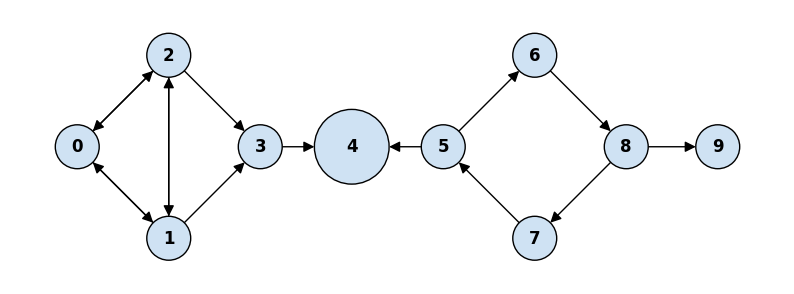

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))

node_pos = {
  0: (0, 2), 1: (1, 1), 2: (1, 3), 3: (2, 2), 4: (3, 2),
  5: (4, 2), 6: (5, 3), 7:(5, 1), 8: (6, 2), 9: (7, 2)}
nx.draw(GDir, pos=node_pos,
  node_size=[(100*size)**3 for size in pr_values],
  with_labels=True, font_weight="bold", arrowsize=16,
  node_color="#cfe2f3", edgecolors="k", ax=ax)

ax.set_aspect("equal")
ax.set_ylim([0.5, 3.5])
print("The DataSciencester network sized by eigenvector centrality")
plt.show(fig)